由于数据量较大，使用 Jupyter Notebook 只需要读一次，之后这些数据一直在内存里面，可以随时使用。并且其呈现的交互式编程方式便于阅读。

In [1]:
import pandas as pd

#导入数据
data = pd.read_excel(r'C:\Users\Windows\Desktop\模拟数据.xlsx')
#查看前几条数据
data.head()


,订单号,用户ID,商品编码,商品名称,支付单价,件数,发货主体,日期
0,4201226870700990,113681,14781,彩虹5号电池（10粒装） 标准装,9.90,1,11,20201201
1,4201221725400090,118203,249208,小闲马桶清洁剂800g/瓶 3瓶装,39.92,1,65,20201201
2,4201229973301400,118391,242996,抽绳式垃圾袋3卷,19.80,2,11,20201201
3,4201202160405370,120862,253309,贵州茅台飞天酒53度 酱香型白酒500ml,1499.00,1,451,20201201
4,4201223773404480,121810,74300,90分男子防泼水摇粒绒夹克 黑色 L,59.00,1,28,20201201


In [2]:
#查看属性类型以及统计是否存在缺失值
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
订单号     1048575 non-null int64
用户ID    1048575 non-null int64
商品编码    1048575 non-null int64
商品名称    1048575 non-null object
支付单价    1048575 non-null float64
件数      1048575 non-null int64
发货主体    1048575 non-null int64
日期      1048575 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 64.0+ MB


从上述结果发现：各属性均不存在缺失值

## 一、使用SQL提取代码，统计合单率  
此处使用SQL Server。
#### 关于合并订单，经过查阅资料以及自身理解在分析前给与其定义：同一用户同时下单多件物品（物品可以来源不同发货主体）时产生，此时寄往同一地址的多件物品将合并成一个订单即存在相同的订单号。
#### 以天为统计单位，合单率即为任意一天“存在合单情况的去重订单编号个数/总的去重订单编号个数”。如某天存在3条记录，对应的订单编号分别为{11  用户A、11 用户A、21 用户B},则当天合单率为1/2=50%。

### 步骤1：在执行查询过程中，发现存在异常数据，需要进行数据清洗。异常如下图所示
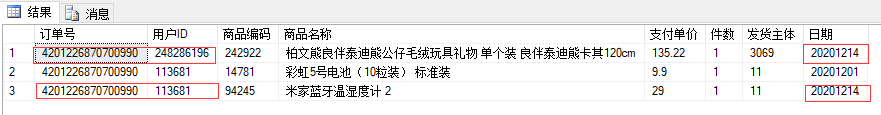

从上图可以发现存在同一天的同一订单号对应到了不同用户ID的异常情况，在后续分析前需要先剔除。

In [3]:
#异常数据剔除:data 需要清洗的某一天的数据

def clean(data):
    
    data = data.sort_values(by = '订单号',axis = 0,ascending = True)
    data = data.reset_index(drop=True)
    #创建一个新的数据框存储清洗后的数据
    data_clean = pd.DataFrame(columns = data.columns.to_list())
    
    #异常数据均是订单编号数出现至少两次
    
    order_count = data['订单号'].value_counts(ascending = True) #统计订单编号出现频次
    df_order_count = pd.DataFrame(order_count)  #将词频结果转成DataFrame格式
    dic = dict(zip(df_order_count.index.values.tolist(),df_order_count.订单号.tolist())) #转成字典
    
    #筛选出出现一次以及出现多次的订单编号
    order1 = []
    d1 = {}
    for  k,v in dic.items():
        if v == 1:
            order1.append(k)
        else:
            d1[k] = v
    d1 = sorted(d1.items(), key=lambda d:d[0],reverse = True)      
    d1 = dict(d1)
    
    #取出订单编号出现一次的值放在新数据框中
    
    for i in range(len(order1)):
        order = order1[i]
        
        for j in range(data.shape[0]):
            if  data.loc[j]['订单号'] == order:
                data_clean = data_clean.append(data.loc[j], ignore_index=True)
                break
    
   
    #剩余的订单编号删除异常的 —— 同一单号 用户ID不同
    for k,v in d1.items():
        for j in range(data.shape[0]):
            if  data.loc[j]['订单号'] == k:
                temp = data[j:j+v]
                #判断是否日期，用户ID、发货主体是否一致
                if len(temp['用户ID'].value_counts()) != 1:
                    break
                else:
                    data_clean = data_clean.append(temp,ignore_index=True)
                    break
    
    
    return data_clean
    

In [9]:
data_clean = pd.DataFrame(columns = data.columns.to_list())
for i in range(31):
    DATA = data[data['日期']==20201201+i]
    clean = clean(DATA)
    data_clean = data_clean.append(clean,ignore_index=True)
#清洗后的数据保存到文件中
data_clean.to_excel(r'C:\Users\Windows\Desktop\清洗后的模拟数据.xlsx')

### 步骤2：编写SQL计算合单率，代码如下所示

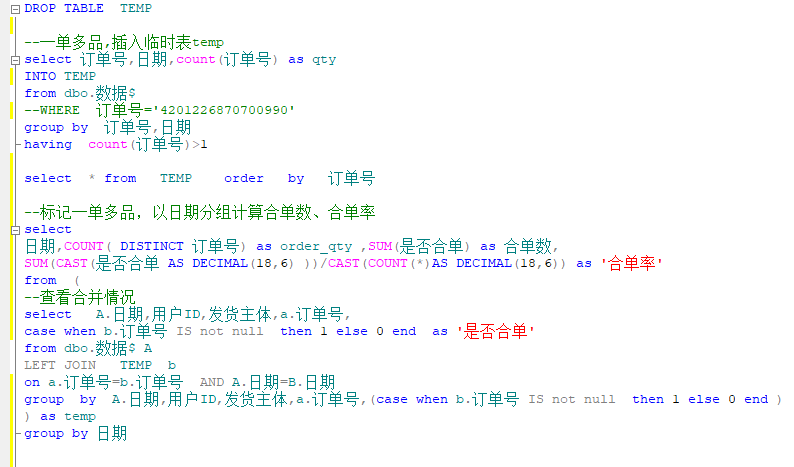

运行结果保存至excel中，具体数值表现如下：

In [49]:
comb_order = pd.read_excel(r'C:\Users\Windows\Desktop\合单率.xlsx')
comb_order['合单率'] = comb_order['合单率'].apply(lambda x: format(x, '.2%'))
comb_order

,日期,订单数,合单数,合单率
0,20201201,20719,40,0.19%
1,20201202,26538,67,0.25%
2,20201203,32118,77,0.24%
3,20201204,51151,212,0.41%
4,20201205,60881,292,0.48%
5,20201206,60851,323,0.53%
6,20201207,28270,89,0.31%
7,20201208,39179,124,0.32%
8,20201209,63878,257,0.40%
9,20201210,54673,200,0.37%


## 二、利用Excel数据分析

筛出每天存在合单的订单记录并保存至excel中

In [37]:
#导入数据
Data = pd.read_csv(r'C:\Users\Windows\Desktop\清洗后的数据.csv')
hd = pd.DataFrame(columns = data.columns.to_list())
for i in range(31):
    temp = Data[Data['日期']== 20201201+i]
    order_count = temp['订单号'].value_counts(ascending=True)  # 统计订单编号出现频次
    df_order_count = pd.DataFrame(order_count)  # 将词频结果转成DataFrame格式
    dic = dict(zip(df_order_count.index.values.tolist(), df_order_count.订单号.tolist()))  # 转成字典

    # 筛选出出现多次的订单编号
    order = []
    for k, v in dic.items():
        if v != 1:
            hd = hd.append(temp[temp['订单号']==k],ignore_index=True)

hd = hd.sort_values(by='日期')
hd.to_excel(r'C:\Users\Windows\Desktop\合单记录.xlsx')